In [1]:
import calim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import time
import scipy
from datetime import datetime

import sys
import os
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path+"\\custom_functs")

from modules import customfunctions as cf

# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")


In [2]:
list_files = ["doppel_perf_ctrl_cal_FebMar2023_230307.hdf",
              "doppel_perf_old_data_only_ctrl_230307.hdf",
             "doppel_perf_old_data_no_ctrl_230307.hdf",
             "doppel_perf_cal_FebMar2023_230309.hdf"]
data_hdf = cf.concat_hdf_files(list_files)

Concatenate 4 files:
doppel_perf_ctrl_cal_FebMar2023_230307.hdf
doppel_perf_old_data_only_ctrl_230307.hdf
doppel_perf_old_data_no_ctrl_230307.hdf
doppel_perf_cal_FebMar2023_230309.hdf
Done.


In [3]:
def get_binned_events(cell, start, end, bin_size, align="left"):
    st1 = time.time() # Get start time
    
    binned_events = np.array([])
    
    events = np.array(cell.get_event_list())
    
    
    # Only consider those events between start and smaller than end
    events = events[(events >= start) & (events < end)]
    
    if align == "left":
        bins = np.array(list(range(start, end, bin_size)))
        inds = np.digitize(events, bins)

    if align == "right":
        bins = np.flip(np.array(list(range(end, start, -bin_size))))

        inds = np.digitize(events, bins, right=True)

    
    return_values = np.zeros(len(bins))
    bin_unique, bin_counts = np.unique(inds, return_counts=True)
    for i,x in enumerate(bin_unique):
        if align == "left":
            return_values[x-1] = bin_counts[i]
        if align == "right":
            return_values[x] = bin_counts[i]
    
    
    if align == "left":
        bins = np.append(bins, end)
    elif align == "right":
        bins = np.append(start, bins)
    return return_values, bins

In [4]:
max_length = 16200 # maximum number of frames to consider

data_left = pd.DataFrame()

bin_size = 60 # Bin size in seconds

n_rec = len(data_hdf.recordings)
print(f"Processing {n_rec} recordings")

for i, recording in enumerate(data_hdf.recordings):
    print(f"Processing recording {(i+1)}/{n_rec}: {recording}")

    r = data_hdf.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}

    for cell in r.cells:
        c = r.cells[cell]

        if c.use:
            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables


                if info["start"] < max_length:  # only process conditions with a start < max_length
                    if info["end"] > max_length:  # if the end is longer than max_length
                        info["end"] = max_length  # set end to max_length

                    #calculate actvity in last 2 min of each condition in  events/s
                    frames_120s = int(120/r.dt)
                    info["num_events_last120s"]  = len(list(c.get_event(range(info["end"]-frames_120s, info["end"])))) # Number of events

                    if info["num_events_last120s"] == 0:
                        info["num_events_last120s"] = 0
                        info["activity_last120s"] = 0
                    else:
                        info["activity_last120s"] =  info["num_events_last120s"]/frames_120s/r.dt 

                    #calculate bins

                    bin_count, bins = get_binned_events(c, info["start"], info["end"], int(bin_size/r.dt), align="left")

                    for i, bc in enumerate(bin_count):
                        info["freq_left"] = bc/(np.diff(bins)[i]*r.dt)
                        info["bins_left"] = bins[i]
                        data_left = pd.concat((data_left, pd.DataFrame.from_dict(info, orient="index").T), ignore_index=True)


data_left['date'] = data_left['recording'].str[0:6]
data_left['bins_left'] = data_left['bins_left'].astype(int)
data_left['start'] = data_left['start'].astype(int)
data_left['end'] = data_left['end'].astype(int)

data_left = data_left.round({'bins_left': -1})
data_left = data_left.round({'start': -1})
data_left = data_left.round({'end': -1})

data_left["bins_left_v2"]=data_left["bins_left"]-data_left["start"]

print("Done.")

Processing 21 recordings
Processing recording 1/21: 230223_slice05_500pM_AngII_ctrl_results.ome.csv
Processing recording 2/21: 230224_slice02_500pM_AngII_ctrl_results.csv
Processing recording 3/21: 230224_slice03_500pM_AngII_ctrl_results.csv
Processing recording 4/21: 230227_slice01_500pM_AngII_ctrl_results.csv
Processing recording 5/21: 230228_slice01_500pM_AngII_ctrl_results.csv
Processing recording 6/21: 230302_slice03_500pM_AngII_ctrl_results.csv
Processing recording 7/21: 230302_slice06_500pM_AngII_ctrl_results.csv
Processing recording 8/21: 220601_slice03_rec01_ctrl_dp_results.csv
Processing recording 9/21: 220603_slice03_rec01_ctrl_dp_results.csv
Processing recording 10/21: 220607_slice03_rec01_ctrl_dp_results.csv
Processing recording 11/21: 220610_slice03_rec01_ctrl_dp_results.csv
Processing recording 12/21: 220601_slice01_rec01_5TTAP2_300isra_1_MMStack_Results.csv
Processing recording 13/21: 220601_slice02_rec01_5TTAP2_300isra_1_MMStack_Results.csv
Processing recording 14/21: 

In [5]:
max_length = 16200 # maximum number of frames to consider

data_right = pd.DataFrame()

bin_size = 60 # Bin size in seconds

n_rec = len(data_hdf.recordings)
print(f"Processing {n_rec} recordings:")

for i, recording in enumerate(data_hdf.recordings):
    print(f"Processing recording {(i+1)}/{n_rec}: {recording}")

    r = data_hdf.recordings[recording]

    info = {desc: r.information[desc] for desc in r.information}

    for cell in r.cells:
        c = r.cells[cell]

        if c.use:
            for con in r.conditions:
                info["recording"] = recording
                info["start"] = int(con.start)
                info["end"] = int(con.end)
                info["cell"] = cell
                info["dt"] = r.dt # Add "dt" aka seconds/frame
                info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables
                
                if info["start"] < max_length:  # only process conditions with a start < max_length
                    if info["end"] > max_length:  # if the end is longer than max_length
                        info["end"] = max_length  # set end to max_length

                    #calculate actvity in last 2 min of each condition in  events/s
                    frames_120s = int(120/r.dt)
                    info["num_events_last120s"]  = len(list(c.get_event(range(info["end"]-frames_120s, info["end"])))) # Number of events

                    if info["num_events_last120s"] == 0:
                        info["num_events_last120s"] = 0
                        info["activity_last120s"] = 0
                    else:
                        info["activity_last120s"] =  info["num_events_last120s"]/frames_120s/r.dt 

                    #calculate bins

                    bin_count, bins = get_binned_events(c, info["start"], info["end"], int(bin_size/r.dt), align="right")

                    for i, bc in enumerate(bin_count):
                        info["freq_right"] = bc/(np.diff(bins)[i]*r.dt)
                        info["bins_right"] = bins[i]
                        data_right = pd.concat((data_right, pd.DataFrame.from_dict(info, orient="index").T), ignore_index=True)

data_right['date'] = data_right['recording'].str[0:6]
data_right['bins_right'] = data_right['bins_right'].astype(int)
data_right['start'] = data_right['start'].astype(int)
data_right['end'] = data_right['end'].astype(int)

data_right = data_right.round({'bins_right': -1})
data_right = data_right.round({'start': -1})
data_right = data_right.round({'end': -1})

data_right["bins_right_v2"]=data_right["bins_right"]-data_right["end"]

print("Done.")

Processing 21 recordings:
Processing recording 1/21: 230223_slice05_500pM_AngII_ctrl_results.ome.csv
Processing recording 2/21: 230224_slice02_500pM_AngII_ctrl_results.csv
Processing recording 3/21: 230224_slice03_500pM_AngII_ctrl_results.csv
Processing recording 4/21: 230227_slice01_500pM_AngII_ctrl_results.csv
Processing recording 5/21: 230228_slice01_500pM_AngII_ctrl_results.csv
Processing recording 6/21: 230302_slice03_500pM_AngII_ctrl_results.csv
Processing recording 7/21: 230302_slice06_500pM_AngII_ctrl_results.csv
Processing recording 8/21: 220601_slice03_rec01_ctrl_dp_results.csv
Processing recording 9/21: 220603_slice03_rec01_ctrl_dp_results.csv
Processing recording 10/21: 220607_slice03_rec01_ctrl_dp_results.csv
Processing recording 11/21: 220610_slice03_rec01_ctrl_dp_results.csv
Processing recording 12/21: 220601_slice01_rec01_5TTAP2_300isra_1_MMStack_Results.csv
Processing recording 13/21: 220601_slice02_rec01_5TTAP2_300isra_1_MMStack_Results.csv
Processing recording 14/21:

In [6]:
data_left.to_csv("data_left_cal_isra_ttap2_overtime.csv")
data_right.to_csv("data_right_cal_isra_ttap2_overtime.csv")

# Load Data


In [7]:
data_right = pd.read_csv("data_right_cal_isra_ttap2_overtime.csv", index_col="Unnamed: 0")  
data_left = pd.read_csv("data_left_cal_isra_ttap2_overtime.csv", index_col="Unnamed: 0") 

print("Load data")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Load data
###### date and time ######
05-May-2023 15:17


In [8]:
# only analyze WT data
data_right = data_right[data_right["genotype"] == "wt"]
data_left = data_left[data_left["genotype"] == "wt"]

# only analyze data that have activity >=0.17 in the 2 minutes before adding blockers
data_r_minus = data_right[(data_right["pos"]==1) & (data_right["activity_last120s"]<0.17)][["recording", "cell"]]\
                    .drop_duplicates()
data_l_minus = data_left[(data_left["pos"]==1) & (data_left["activity_last120s"]<0.17)][["recording", "cell"]]\
                    .drop_duplicates()
data_filtered_r = pd.merge(data_right, data_r_minus, 
                           how='outer', on=["recording", "cell"], indicator=True).query("_merge == 'left_only'")
data_filtered_l = pd.merge(data_left, data_l_minus, 
                           how='outer', on=["recording", "cell"], indicator=True).query("_merge == 'left_only'")

# keep recording with at least 6 cells 
drop_rec = data_filtered_l[(data_filtered_l["pos"]==1) & (data_filtered_l["bins_left"]==0)]\
            .groupby(["ctrl", "recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_filtered_l = data_filtered_l[~data_filtered_l.recording.isin(drop_rec)]
data_filtered_r = data_filtered_r[~data_filtered_r.recording.isin(drop_rec)]


data_filtered_l_per_slice = data_filtered_l.groupby(["recording",
                                                     "pos",
                                                     "genotype", "bins_left_v2", "ctrl"]).mean().reset_index()

data_filtered_r_per_slice = data_filtered_r.groupby(["recording",
                                                     "pos",
                                                     "genotype", "bins_right_v2", "ctrl"]).mean().reset_index()

C:\Users\dinhha\AppData\Local\Temp\ipykernel_7980\163261502.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "genotype", "bins_left_v2", "ctrl"]).mean().reset_index()
C:\Users\dinhha\AppData\Local\Temp\ipykernel_7980\163261502.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "genotype", "bins_right_v2", "ctrl"]).mean().reset_index()


In [14]:
data_filtered_r.groupby(["ctrl"])["animal", "recording"].nunique()

C:\Users\dinhha\AppData\Local\Temp\ipykernel_8652\1228256029.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_filtered_r.groupby(["ctrl"])["animal", "recording"].nunique()


,animal,recording
ctrl,,
n,6,10
y,9,10


In [11]:
data_filtered_l[(data_filtered_l["pos"]==2)&
                (data_filtered_l["bins_left_v2"]==0)].groupby(["ctrl"])["cell"].count()

ctrl
n    246
y    213
Name: cell, dtype: int64

In [12]:
data_pos1 = data_filtered_r.query('pos == 1').query('bins_right_v2 > -3001')
data_pos2 = data_filtered_l.query('pos == 2').query('bins_left_v2 < 6000')
data_pos3 = data_filtered_l.query('pos == 3').query('bins_left_v2 < 6000')


data_pos1["bins_right_v3"] = data_pos1["bins_right_v2"]/60*data_pos1.dt+1
data_pos2["bins_left_v3"] = data_pos2["bins_left_v2"]/60*data_pos2.dt+1
data_pos3["bins_left_v3"] = (data_pos3["bins_left_v2"] + 6000)/60*data_pos3.dt+1

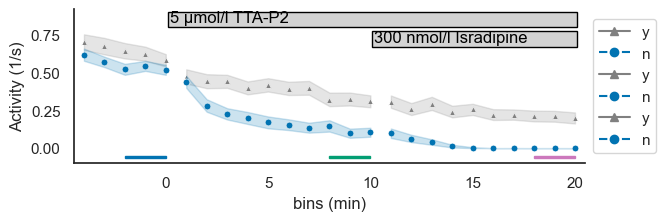

In [13]:
order = ["y", "n"]
m = ["^", "o"]
ms = 5
p = ["grey", color_palette[0]]
lw = 0

fig1, ax1 = plt.subplots(figsize=(6.6,2))
sns.lineplot(data=data_pos1, x="bins_right_v3", y="freq_right", hue = "ctrl", hue_order=order,
               errorbar=("ci",95),n_boot=n_boot, seed=seed,
              style="ctrl", style_order=order, markers=m, 
             palette=p, ms = ms, ax=ax1, zorder=1, linewidth=lw)
            

sns.lineplot(data=data_pos2, x="bins_left_v3", y="freq_left", hue = "ctrl", hue_order=order,
               errorbar=("ci",95),n_boot=n_boot, seed=seed,
              style="ctrl", style_order=order, markers=m, 
             palette=p, ms = ms, ax=ax1, zorder=1, linewidth=lw)
            

sns.lineplot(data=data_pos3, x="bins_left_v3", y="freq_left", hue = "ctrl", hue_order=order,
               errorbar=("ci",95),n_boot=n_boot, seed=seed,
              style="ctrl", style_order=order, markers=m, 
             palette=p, ms = ms, ax=ax1, zorder=1, linewidth=lw)
            

ax1.set_xlim(-4.5,20.5)
ax1.set_ylim(-0.1,0.92)
ax1.set_xlabel("bins (min)")
   
    
# Create a Rectangle patch isra/ttap2

ax1.add_patch(plt.Rectangle((0.1,0.8), 20, 0.105, facecolor='lightgrey', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=10))
plt.text(0.2, 0.835, "5 µmol/l TTA-P2", ha="left", color="black", zorder=12)    
    
ax1.add_patch(plt.Rectangle((10.1,0.67), 10, 0.105, facecolor='lightgrey', linewidth=1, edgecolor = "black", 
                              clip_on=False, zorder=10))
plt.text(10.2, 0.7, "300 nmol/l Isradipine", ha="left", color="black", zorder=12)        

# Create a Rectangle patch selection

ax1.add_patch(plt.Rectangle((-2,-0.065), 2, 0.015, facecolor=color_palette[0], linewidth=1, edgecolor = color_palette[0], 
                              clip_on=False, zorder=10))

ax1.add_patch(plt.Rectangle((8,-0.065), 2, 0.015, facecolor=color_palette[2], linewidth=1, edgecolor = color_palette[2], 
                              clip_on=False, zorder=10))

ax1.add_patch(plt.Rectangle((18,-0.065), 2, 0.015, facecolor=color_palette[4], linewidth=1, edgecolor = color_palette[4], 
                              clip_on=False, zorder=10))

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine(top=True, right=True)
ax1.set_ylabel("Activity (1/s)")       


